In [10]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.transforms
import seaborn as sns
import math
from math import sqrt, factorial
import re
from itertools import groupby
import scipy
import random
from decimal import Decimal
from operator import itemgetter
import multiprocessing
from CustomFunctions import PCvisualization

def cllct_rslts(result):
    """Uses apply_async's callback to setup up a separate Queue for each process.
    This will allow us to collect the results from different threads."""
    results.extend(result)
def collect_results(result):
    """Uses apply_async's callback to setup up a separate Queue for each process.
    This will allow us to collect the results from different threads."""
    results.append(result)


#some functions that help find angles between planes

#https://keisan.casio.com/exec/system/1223596129
def plane_eq(points):
    p0 = points[0,:]
    p1 = points[1,:]
    p2 = points[2,:]
    v1 = [p1[0]-p0[0], p1[1]-p0[1], p1[2]-p0[2]]
    v2 = [p2[0]-p0[0], p2[1]-p0[1], p2[2]-p0[2]]
    abc = np.cross(v1, v2)
    d = np.array([abc[0]*p0[0], abc[1]*p0[1], abc[2]*p0[2]])
    return abc, d
# Function to find Angle
def distance(a1, b1, c1, a2, b2, c2):
     
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A

def angle(a1, b1, a2, b2):
     
    d = ( a1 * a2 + b1 * b2)
    e1 = math.sqrt( a1 * a1 + b1 * b1)
    e2 = math.sqrt( a2 * a2 + b2 * b2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A
def closest(lst, K):  
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

In [25]:
#get directories and open separated datasets

time_interval = 10 #sec/frame

datadir = 'D:/Aaron/Data/Combined_Confocal_PCA_randomized/'
savedir = datadir + 'alldata/'
if not os.path.exists(savedir):
    os.makedirs(savedir)

TotalFrame = pd.read_csv('D:/Aaron/Data/Combined_Confocal_PCA/Shape_Metrics_transitionPCbins.csv', index_col=0)

nbins = np.max(TotalFrame[[x for x in TotalFrame.columns.to_list() if 'bin' in x]].to_numpy())
#open the centers of the binned PCs
centers = pd.read_csv('D:/Aaron/Data/Combined_Confocal_PCA/PC_bin_centers.csv', index_col=0)

#randomly shuffle the PC1 and PC1 bins pairs in the dataframe
resampled = TotalFrame[['PC1bins','PC2bins']].sample(frac=1).reset_index(drop=True)
TotalFrame['PC1bins'] = resampled['PC1bins']
TotalFrame['PC2bins'] = resampled['PC2bins']

In [19]:
# ################## SIMULATE RANDOM TRANSITIONS FROM A NORMAL DISTIBUTION ##################
# #create the normal distributions of both "PCs"
# sPC1 = np.random.normal(0,1.5,10000)
# sPC2 = np.random.normal(0,1.5,10000)
# #generate a random list of index lengths that will count as individual cell tracks 
# cells = []
# while sum(cells)<len(sPC1):
#     cells.append(random.randint(3,100))
# #subtract the "overage" of the last number 
# cells[-1] = cells[-1] - (sum(cells)-len(sPC1))
# #create actual list of "CellID"s
# CellIDs = []
# for i,x in enumerate(cells):
#     CellIDs.extend([f'Cell {i}']*x)
# #create dataframe
# TotalFrame = 

In [26]:
########### interpolate all transitions so that only individual transitions are made ###########
from CustomFunctions.DetailedBalance import interpolate_2dtrajectory

time_interval = 10 #sec/frame

if (os.path.exists(savedir+'interpolated_PC1-PC2_transitions.csv')) & (os.path.exists(savedir+'interpolated_PC1-PC2_transition_pairs.csv')):
        
    transdf = pd.read_csv(savedir+'interpolated_PC1-PC2_transitions.csv')
    transpairsdf = pd.read_csv(savedir+'interpolated_PC1-PC2_transition_pairs.csv')
    print('Opened transition files')
    
else:

    if __name__ ==  '__main__':
        pool = multiprocessing.Pool(processes=60)
        results = []
        for i, cells in TotalFrame.groupby('CellID'):
            cells = cells.sort_values('frame').reset_index(drop = True)
            runs = list()
            #######https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list
            for k, g in groupby(enumerate(cells['frame']), lambda ix: ix[0] - ix[1]):
                currentrun = list(map(itemgetter(1), g))
                list.append(runs, currentrun)

            for r in runs:
                r = np.array(r, dtype=int)
                #skip runs less than 3 frames long
                if len(r)<2:
                    pass
                else:
                    cell = cells.iloc[[cells[cells.frame==y].index[0] for y in r]]

                    pool.apply_async(interpolate_2dtrajectory, args = (
                        time_interval,
                        cell.CellID.iloc[0],
                        cell.frame.to_list(),
                        cell[['PC1bins','PC2bins']].to_numpy(),
                        ),
                        callback = collect_results)
    pool.close()
    pool.join()


    transdf = pd.DataFrame(sum([r[0] for r in results],[]))
    transdf = transdf.sort_values(by = ['CellID','frame']).reset_index(drop=True)
    transpairsdf = pd.DataFrame(sum([r[1] for r in results],[]))
    transdf.to_csv(savedir+'interpolated_PC1-PC2_transitions.csv')
    transpairsdf.to_csv(savedir+'interpolated_PC1-PC2_transition_pairs.csv')

    print('Calculated transitions')
    
    
    
############## get the counts of cells leaving 
from CustomFunctions.DetailedBalance import get_transition_counts

if os.path.exists(savedir+'PC1-PC2_binned_transition_rates.csv'):
    trans_rate_df = pd.read_csv(savedir+'PC1-PC2_binned_transition_rates.csv')
    print('Opened transition rate files')
else:
    
    #calculate the total time observed during the experiment
    ttot = transdf.time_elapsed.sum()
    
    if __name__ ==  '__main__':
        pool = multiprocessing.Pool(processes=60)
        results = []
        for x in range(nbins):
            for y in range(nbins):
                fromm = transdf[(transdf['from_x'] == x+1) & (transdf['from_y'] == y+1)].reset_index(drop=True).to_dict()
                to = transdf[(transdf['to_x'] == x+1) & (transdf['to_y'] == y+1)].reset_index(drop=True).to_dict()
                pool.apply_async(get_transition_counts, args = (
                    x+1,
                    y+1,
                    fromm,
                    to,
                    ttot,
                    ),
                    callback = collect_results)
    pool.close()
    pool.join()

    trans_rate_df = pd.DataFrame(results)
    trans_rate_df = trans_rate_df.sort_values(by = ['x','y']).reset_index(drop=True)
    trans_rate_df.to_csv(savedir+'PC1-PC2_binned_transition_rates.csv')
    
    print('Calculated transition rates')
    
    
    
from CustomFunctions.DetailedBalance import bootstrap_trajectories

#if a boostrapped data file already exists, load it, otherwise make one
if os.path.exists(savedir+'alldata_boostrapped_transitions.csv'):
    alldatabs = pd.read_csv(savedir+'alldata_boostrapped_transitions.csv', index_col=0)
    avg_cur = alldatabs.groupby(['x','y']).apply(np.mean)
    avg_cur = avg_cur.drop(columns = ['x','y']).reset_index()
    print('Opened bootstrap file')
else:
    #set the total boostrap time to the full time of a single video
    ttot = time_interval*TotalFrame.frame.max()
    
    #number of times to bootstrap
    bsiter = 5000

    start = 0
    stop = 300
    allresults = []
    while start<bsiter:
        if __name__ ==  '__main__':
            pool = multiprocessing.Pool(processes=60)
            results = []
            for x in range(start,stop):
                pool.apply_async(bootstrap_trajectories, args = (
                    transpairsdf,
                    ttot,
                    nbins,
                    ),
                    callback = collect_results)
            pool.close()
            pool.join()

            allresults.extend(results)

        start = stop + 1
        stop = stop + 300
        if stop>bsiter:
            stop = bsiter
        print(f'Finished {start} iterations, beginning the next {stop-start}')
    bslist = allresults.copy()
    # del results
    # del allresults
    avg_cur = pd.concat(bslist)
    avg_cur.to_csv(savedir+'alldata_boostrapped_transitions.csv')
    avg_cur = avg_cur.groupby(['x','y']).apply(np.mean)
    avg_cur = avg_cur.drop(columns = ['x','y']).reset_index()

    print('Finished boostrapping')
    
#get current field for this bootstrap realization
bsfield = []
for x in range(nbins):
    for y in range(nbins):
        current = avg_cur[(avg_cur['x'] == x+1) & (avg_cur['y'] == y+1)]
        cov = np.cov(np.array([[-current.x_minus_rate.values[0]/2, current.x_plus_rate.values[0]/2,0,0],
                [0,0,-current.y_minus_rate.values[0]/2, current.y_plus_rate.values[0]/2]]))
        evals, evecs = np.linalg.eigh(cov)
        bsfield.append({'x':x+1,
                        'y':y+1,
                        'eval1':evals[1],
                        'eval2':evals[0],
                       'evec1x':evecs[0,1],
                       'evec1y':evecs[1,1],
                       'evec2x':evecs[0,0],
                       'evec2y':evecs[1,0]})
        
bsframe = pd.DataFrame(bsfield)

Calculated transitions
Calculated transition rates
Finished 301 iterations, beginning the next 299
Finished 601 iterations, beginning the next 299
Finished 901 iterations, beginning the next 299
Finished 1201 iterations, beginning the next 299
Finished 1501 iterations, beginning the next 299
Finished 1801 iterations, beginning the next 299
Finished 2101 iterations, beginning the next 299
Finished 2401 iterations, beginning the next 299
Finished 2701 iterations, beginning the next 299
Finished 3001 iterations, beginning the next 299
Finished 3301 iterations, beginning the next 299
Finished 3601 iterations, beginning the next 299
Finished 3901 iterations, beginning the next 299
Finished 4201 iterations, beginning the next 299
Finished 4501 iterations, beginning the next 299
Finished 4801 iterations, beginning the next 199
Finished 5001 iterations, beginning the next -1
Finished boostrapping


C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator


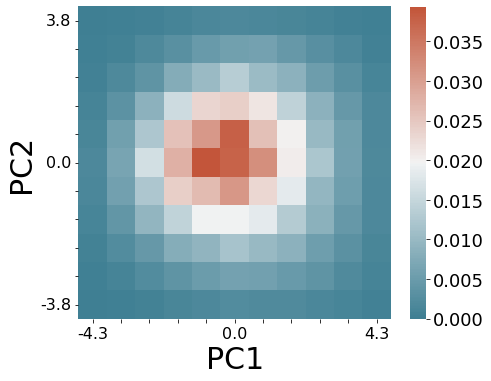

In [28]:
################ heatmap of probability density #############
#calculate the total time observed during the experiment
ttot = transdf.time_elapsed.sum()

#make numpy array with heatmap data
bighm = np.zeros((nbins,nbins))
#get total time observed in the system

for x in range(nbins):
    for y in range(nbins):
        current =  transdf[(transdf['from_x'] == x+1) & (transdf['from_y'] == y+1)]
        if current.empty:
            bighm[y,x] = 0
        else:
            bighm[y,x] = current.time_elapsed.sum()/ttot

#plot heatmap with seaborn
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.heatmap(
    bighm,
    vmin=0, vmax=bighm.max(), #center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'shrink': 0.82}
)
ax.set_xticklabels(
    [round(x,1) for x in centers.PC1.to_list()],
    fontsize = 16
)
ax.set_yticklabels(
    [round(x,1) for x in centers.PC2.to_list()],
    rotation=0,
    fontsize = 16
)
#take out all axis labels except the desired ones
for i, l in enumerate(ax.xaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
for i, l in enumerate(ax.yaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
#set axis titles
ax.set_xlabel('PC1', fontsize = 30)
ax.set_ylabel('PC2', fontsize = 30)
# adjust colorbar tick label size
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=18)
#correct axis orientations
ax.invert_yaxis()
# #set title
# ax.set_title('Probability Density (sec)', fontsize = 22)

plt.savefig(savedir + 'PC1_PC2 probability density heatmap.png', bbox_inches='tight')

NameError: name 'PC1bins' is not defined

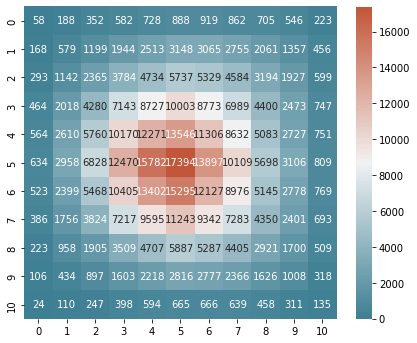

In [29]:
################ PLOT THE COUNTS OF THE BINS #############
#calculate the total time observed during the experiment
ttot = transdf.time_elapsed.sum()

#make numpy array with heatmap data
bighm = np.zeros((nbins,nbins))
#get total time observed in the system

for x in range(nbins):
    for y in range(nbins):
        current =  transdf[(transdf['from_x'] == x+1) & (transdf['from_y'] == y+1)]
        if current.empty:
            bighm[y,x] = 0
        else:
            bighm[y,x] = len(current)

#plot heatmap with seaborn
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.heatmap(
    bighm,
    vmin=0, vmax=bighm.max(), #center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    annot = True,
    fmt = '.0f',
    ax = ax,
    cbar_kws={'shrink': 0.82}
)
ax.set_xticklabels(
    [round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])],
    fontsize = 16
)
ax.set_yticklabels(
    [round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])],
    rotation=0,
    fontsize = 16
)
#take out all axis labels except the desired ones
for i, l in enumerate(ax.xaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
for i, l in enumerate(ax.yaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
#set axis titles
ax.set_xlabel('PC1', fontsize = 30)
ax.set_ylabel('PC2', fontsize = 30)
# adjust colorbar tick label size
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=18)
#correct axis orientations
ax.invert_yaxis()
# #set title
# ax.set_title('Probability Density (sec)', fontsize = 22)

plt.savefig(savedir + 'PC1_PC2 probability density heatmap.png', bbox_inches='tight')

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator


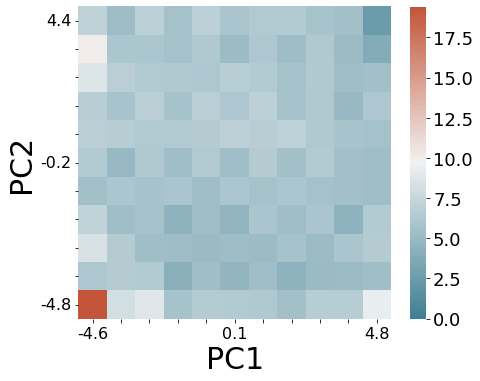

In [10]:
################ heatmap of AVERAGE DWELL TIME #############

#make numpy array with heatmap data
bighm = np.zeros((nbins,nbins))
#get total time observed in the system

for x in range(nbins):
    for y in range(nbins):
        current =  transdf[(transdf['from_x'] == x+1) & (transdf['from_y'] == y+1)]
        if current.empty:
            bighm[y,x] = 0
        else:
            bighm[y,x] = current.time_elapsed.mean()

#plot heatmap with seaborn
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.heatmap(
    bighm,
    vmin=0, vmax=bighm.max(), #center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True,
    xticklabels = True,
    yticklabels = True,
    cbar_kws={'shrink': 0.82}
)
ax.set_xticklabels(
    [round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])],
    fontsize = 16
)
ax.set_yticklabels(
    [round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])],
    rotation=0,
    fontsize = 16
)
#take out all axis labels except the desired ones
for i, l in enumerate(ax.xaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
for i, l in enumerate(ax.yaxis.get_ticklabels()):
    if i%5 != 0:
        l.set_visible(False)
#set axis titles
ax.set_xlabel('PC1', fontsize = 30)
ax.set_ylabel('PC2', fontsize = 30)
# adjust colorbar tick label size
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=18)
#correct axis orientations
ax.invert_yaxis()
# #set title
# ax.set_title('Probability Density (sec)', fontsize = 22)

plt.savefig(savedir + 'PC1_PC2 avg dwell time heatmap.png', bbox_inches='tight')

In [ ]:
########## PC1/PC2 transition with error ellipses oriented to PCs ################

from cmocean import cm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse, Rectangle
from CustomFunctions.DetailedBalance import contour_coords


# inverse scale for arrows
scale = 0.0005

# combine fake error data with real transition data
elldf = bsframe.merge(trans_rate_df,left_on = ['x','y'], right_on = ['x','y'])


norm = matplotlib.colors.Normalize()
norm.autoscale([0,360])
cmm = cm.phase
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(220, 20, n=180).as_hex()),
              'value':list(np.arange(0,180,1))})


meshdir = datadir + 'PC_Meshes/'

proj=[0,1]
PCkey = [1,2]
binkey = [1,5]      

fig = plt.figure(figsize=(10,10))

graphaxes, axes = PCvisualization.get_contours_for_axes(meshdir,
                proj,
                PCkey,
                binkey,
                )

    

#add "grid lines" first 
for h in np.linspace(0.5, nbins+0.5, nbins+1):
    graphaxes[0].axhline(h, linestyle='-', color='grey', alpha=0.3, zorder = 0 * 5) # horizontal lines
    graphaxes[0].axvline(h, linestyle='-', color='grey', alpha=0.3, zorder = 0 * 5) # vertical lines

#add contou line if desired
uple = [3,8]
lori = [8,4]
contourcoords = contour_coords(uple,lori)

#actually plot the contour
graphaxes[0].plot(np.array(contourcoords)[:,0], np.array(contourcoords)[:,1], lw=8,color='black',alpha=0.3, zorder = 1 * 5)

    
    
for x in range(1,nbins+1):
    for y in range(1,nbins+1):
        current = elldf[(elldf['x'] == x) & (elldf['y'] == y)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
        
        ell = Ellipse(xy=(x+(xcurrent.values*(1/scale)),y+(ycurrent.values*(1/scale))),
                width=np.sqrt(current.eval1)*(1/scale)*2,
                  height=np.sqrt(current.eval2)*(1/scale)*2,
                angle=np.arctan2(current.evec1y,current.evec1x))
        graphaxes[0].add_artist(ell)
        ell.set_alpha(0.2)
        ell.set_zorder(2 * 5)
#         print(np.sqrt(current.eval1), np.sqrt(current.eval2))

for x in range(1,nbins+1):
    for y in range(1,nbins+1):
        current = elldf[(elldf['x'] == x) & (elldf['y'] == y)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
        anglecolor = (np.arctan2(xcurrent,ycurrent) *180/np.pi)+180
        graphaxes[0].quiver(x,
                   y, 
                   xcurrent,
                   ycurrent,
                  angles = 'xy',
                  scale_units = 'xy',
                  scale = scale,
#                   width = 0.012,
#                   minlength = 0.8,
                  color = cmm(norm(anglecolor)),
                    zorder = 3 * 5)
    

#         print(x, x+(xcurrent.values*scale),y,  y+(ycurrent.values*scale))
graphaxes[0].set_xlabel('PC1', fontsize = 34)
graphaxes[0].set_ylabel('PC2', fontsize = 34)
graphaxes[0].set_xticks(list(range(1,nbins+1)),[round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])], fontsize = 18)
graphaxes[0].set_yticks(list(range(1,nbins+1)),[round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])], fontsize = 18)
graphaxes[0].set_xlim(0,nbins+1)
graphaxes[0].set_ylim(0,nbins+1)

#legend background
lxp = 0.125
lyp = 10.25
rect = Rectangle((lxp, lyp), 1.625, 1.625, linewidth=1, edgecolor='black', facecolor='#80858a')
graphaxes[0].add_patch(rect)
rect.set_zorder(4 * 5)
#x-axis legend arrow
graphaxes[0].quiver(lxp+0.5,lyp+0.5,1*scale,0,angles = 'xy',scale_units = 'xy',scale = scale,color = "white",zorder = 4 * 5)
#x-axis legend text
xsc = f'{(np.diff(PC2bins).mean()/time_interval)*scale:.1e}'
xsc = xsc.split('-')[0] + str(int(xsc.split('e')[1]))
graphaxes[0].text(lxp+0.3,lyp+0.05,xsc+' $s^{-1}$', color = 'white', fontweight = 'bold',zorder = 4 * 5)
#y-axis legend arrow
graphaxes[0].quiver(lxp+0.5,lyp+0.5,0,1*scale,angles = 'xy',scale_units = 'xy',scale = scale,color = 'white',zorder = 4 * 5)
#y-axis legend text
ysc = f'{(np.diff(PC2bins).mean()/time_interval)*scale:.1e}'
ysc = ysc.split('-')[0] + str(int(ysc.split('e')[1]))
graphaxes[0].text(lxp+0.05,lyp+0.3,ysc+' $s^{-1}$', rotation = 'vertical', color = 'white', fontweight = 'bold',zorder = 4 * 5)

                  

# __a__=np.arange(0,1000*np.pi, np.pi/1.61803398875)
# __r__=0.3+np.log(1+np.arange(0, len(__a__))/len(__a__))
# ax.scatter(1-20+1*__r__*np.cos(__a__), 1+10*__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
# ax.scatter(1.5+__r__*np.cos(__a__), 14+__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
plt.tight_layout()



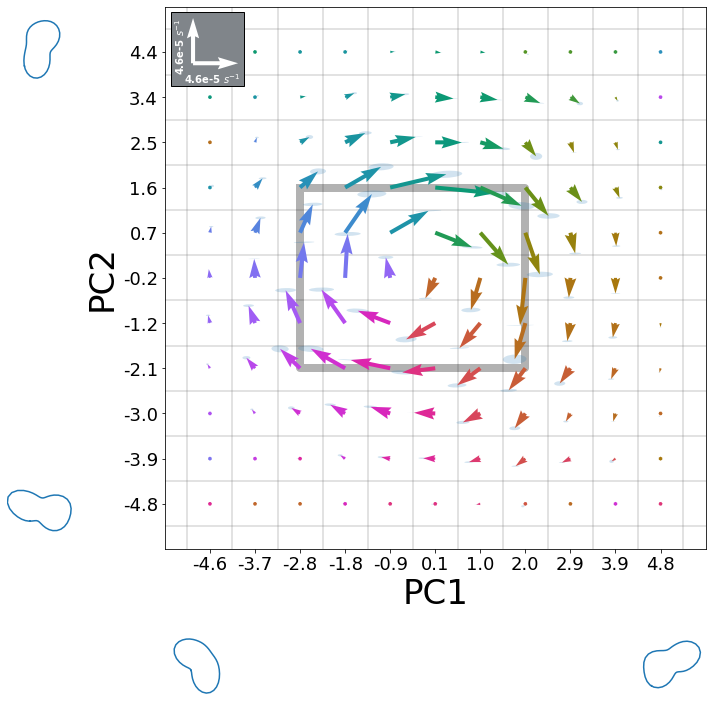

In [29]:
########## PC1/PC2 transition with error ellipses oriented to PCs ################

from cmocean import cm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse, Rectangle
from CustomFunctions.DetailedBalance import contour_coords


# inverse scale for arrows
scale = 0.0005

# combine fake error data with real transition data
elldf = bsframe.merge(trans_rate_df,left_on = ['x','y'], right_on = ['x','y'])


norm = matplotlib.colors.Normalize()
norm.autoscale([0,360])
cmm = cm.phase
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(220, 20, n=180).as_hex()),
              'value':list(np.arange(0,180,1))})


meshdir = datadir + 'PC_Meshes/'

proj=[0,1]
PCkey = [1,2]
binkey = [1,5]      

fig = plt.figure(figsize=(10,10))

graphaxes, axes = PCvisualization.get_contours_for_axes(meshdir,
                proj,
                PCkey,
                binkey,
                )

    

#add "grid lines" first 
for h in np.linspace(0.5, nbins+0.5, nbins+1):
    graphaxes[0].axhline(h, linestyle='-', color='grey', alpha=0.3, zorder = 0 * 5) # horizontal lines
    graphaxes[0].axvline(h, linestyle='-', color='grey', alpha=0.3, zorder = 0 * 5) # vertical lines

#add contou line if desired
uple = [3,8]
lori = [8,4]
contourcoords = contour_coords(uple,lori)

#actually plot the contour
graphaxes[0].plot(np.array(contourcoords)[:,0], np.array(contourcoords)[:,1], lw=8,color='black',alpha=0.3, zorder = 1 * 5)

    
    
for x in range(1,nbins+1):
    for y in range(1,nbins+1):
        current = elldf[(elldf['x'] == x) & (elldf['y'] == y)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
        
        ell = Ellipse(xy=(x+(xcurrent.values*(1/scale)),y+(ycurrent.values*(1/scale))),
                width=np.sqrt(current.eval1)*(1/scale)*2,
                  height=np.sqrt(current.eval2)*(1/scale)*2,
                angle=np.arctan2(current.evec1y,current.evec1x))
        graphaxes[0].add_artist(ell)
        ell.set_alpha(0.2)
        ell.set_zorder(2 * 5)
#         print(np.sqrt(current.eval1), np.sqrt(current.eval2))

for x in range(1,nbins+1):
    for y in range(1,nbins+1):
        current = elldf[(elldf['x'] == x) & (elldf['y'] == y)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
        anglecolor = (np.arctan2(xcurrent,ycurrent) *180/np.pi)+180
        graphaxes[0].quiver(x,
                   y, 
                   xcurrent,
                   ycurrent,
                  angles = 'xy',
                  scale_units = 'xy',
                  scale = scale,
#                   width = 0.012,
#                   minlength = 0.8,
                  color = cmm(norm(anglecolor)),
                    zorder = 3 * 5)
    

#         print(x, x+(xcurrent.values*scale),y,  y+(ycurrent.values*scale))
graphaxes[0].set_xlabel('PC1', fontsize = 34)
graphaxes[0].set_ylabel('PC2', fontsize = 34)
graphaxes[0].set_xticks(list(range(1,nbins+1)),[round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])], fontsize = 18)
graphaxes[0].set_yticks(list(range(1,nbins+1)),[round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])], fontsize = 18)
graphaxes[0].set_xlim(0,nbins+1)
graphaxes[0].set_ylim(0,nbins+1)

#legend background
lxp = 0.125
lyp = 10.25
rect = Rectangle((lxp, lyp), 1.625, 1.625, linewidth=1, edgecolor='black', facecolor='#80858a')
graphaxes[0].add_patch(rect)
rect.set_zorder(4 * 5)
#x-axis legend arrow
graphaxes[0].quiver(lxp+0.5,lyp+0.5,1*scale,0,angles = 'xy',scale_units = 'xy',scale = scale,color = "white",zorder = 4 * 5)
#x-axis legend text
xsc = f'{(np.diff(PC2bins).mean()/time_interval)*scale:.1e}'
xsc = xsc.split('-')[0] + str(int(xsc.split('e')[1]))
graphaxes[0].text(lxp+0.3,lyp+0.05,xsc+' $s^{-1}$', color = 'white', fontweight = 'bold',zorder = 4 * 5)
#y-axis legend arrow
graphaxes[0].quiver(lxp+0.5,lyp+0.5,0,1*scale,angles = 'xy',scale_units = 'xy',scale = scale,color = 'white',zorder = 4 * 5)
#y-axis legend text
ysc = f'{(np.diff(PC2bins).mean()/time_interval)*scale:.1e}'
ysc = ysc.split('-')[0] + str(int(ysc.split('e')[1]))
graphaxes[0].text(lxp+0.05,lyp+0.3,ysc+' $s^{-1}$', rotation = 'vertical', color = 'white', fontweight = 'bold',zorder = 4 * 5)

                  

# __a__=np.arange(0,1000*np.pi, np.pi/1.61803398875)
# __r__=0.3+np.log(1+np.arange(0, len(__a__))/len(__a__))
# ax.scatter(1-20+1*__r__*np.cos(__a__), 1+10*__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
# ax.scatter(1.5+__r__*np.cos(__a__), 14+__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
plt.tight_layout()



NameError: name 'PC1bins' is not defined

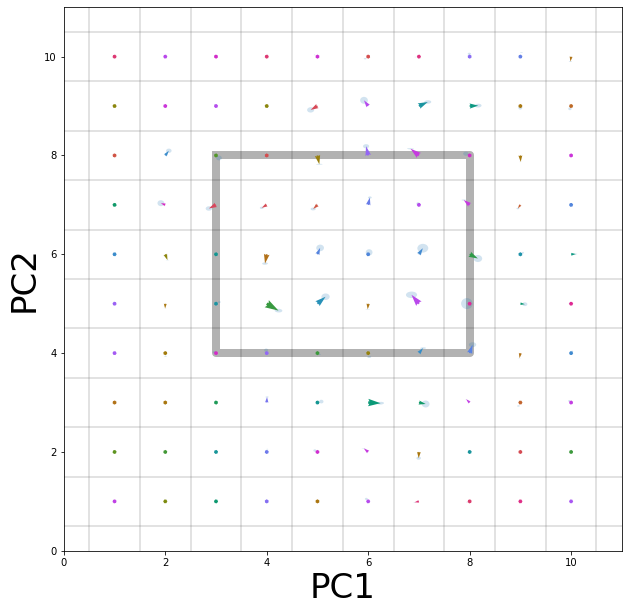

In [23]:
########## PC1/PC2 transition with error ellipses oriented to PCs WITHOUT PC MESH SLICES ################

from cmocean import cm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse, Rectangle
from CustomFunctions.DetailedBalance import contour_coords


# inverse scale for arrows
scale = 0.0005

# combine fake error data with real transition data
elldf = bsframe.merge(trans_rate_df,left_on = ['x','y'], right_on = ['x','y'])


norm = matplotlib.colors.Normalize()
norm.autoscale([0,360])
cmm = cm.phase
color_scale = pd.DataFrame({'color':list(sns.diverging_palette(220, 20, n=180).as_hex()),
              'value':list(np.arange(0,180,1))})


meshdir = datadir + 'PC_Meshes/'

proj=[0,1]
PCkey = [1,2]
binkey = [1,5]      

fig, ax = plt.subplots(figsize=(10,10))
    

#add "grid lines" first 
for h in np.linspace(0.5, nbins+0.5, nbins+1):
    ax.axhline(h, linestyle='-', color='grey', alpha=0.3, zorder = 0 * 5) # horizontal lines
    ax.axvline(h, linestyle='-', color='grey', alpha=0.3, zorder = 0 * 5) # vertical lines

#add contou line if desired
uple = [3,8]
lori = [8,4]
contourcoords = contour_coords(uple,lori)

#actually plot the contour
ax.plot(np.array(contourcoords)[:,0], np.array(contourcoords)[:,1], lw=8,color='black',alpha=0.3, zorder = 1 * 5)

    
    
for x in range(1,nbins+1):
    for y in range(1,nbins+1):
        current = elldf[(elldf['x'] == x) & (elldf['y'] == y)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
        
        ell = Ellipse(xy=(x+(xcurrent.values*(1/scale)),y+(ycurrent.values*(1/scale))),
                width=np.sqrt(current.eval1)*(1/scale)*2,
                  height=np.sqrt(current.eval2)*(1/scale)*2,
                angle=np.arctan2(current.evec1y,current.evec1x))
        ax.add_artist(ell)
        ell.set_alpha(0.2)
        ell.set_zorder(2 * 5)
#         print(np.sqrt(current.eval1), np.sqrt(current.eval2))

for x in range(1,nbins+1):
    for y in range(1,nbins+1):
        current = elldf[(elldf['x'] == x) & (elldf['y'] == y)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
        anglecolor = (np.arctan2(xcurrent,ycurrent) *180/np.pi)+180
        ax.quiver(x,
                   y, 
                   xcurrent,
                   ycurrent,
                  angles = 'xy',
                  scale_units = 'xy',
                  scale = scale,
#                   width = 0.012,
#                   minlength = 0.8,
                  color = cmm(norm(anglecolor)),
                    zorder = 3 * 5)
    

#         print(x, x+(xcurrent.values*scale),y,  y+(ycurrent.values*scale))
ax.set_xlabel('PC1', fontsize = 34)
ax.set_ylabel('PC2', fontsize = 34)
ax.set_xticks(list(range(1,nbins+1)),[round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])], fontsize = 18)
ax.set_yticks(list(range(1,nbins+1)),[round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])], fontsize = 18)
ax.set_xlim(0,nbins+1)
ax.set_ylim(0,nbins+1)

#legend background
lxp = 0.125
lyp = 10.25
rect = Rectangle((lxp, lyp), 1.645, 1.625, linewidth=1, edgecolor='black', facecolor='#80858a')
ax.add_patch(rect)
rect.set_zorder(4 * 5)
#x-axis legend arrow
ax.quiver(lxp+0.5,lyp+0.5,1*scale,0,angles = 'xy',scale_units = 'xy',scale = scale,color = "white",zorder = 4 * 5)
#x-axis legend text
xsc = f'{(np.diff(PC2bins).mean()/time_interval)*scale:.1e}'
xsc = xsc.split('-')[0] + str(int(xsc.split('e')[1]))
ax.text(lxp+0.25,lyp+0.05,xsc+' $s^{-1}$', color = 'white', fontsize = 13, fontweight = 'bold',zorder = 4 * 5)
#y-axis legend arrow
ax.quiver(lxp+0.5,lyp+0.5,0,1*scale,angles = 'xy',scale_units = 'xy',scale = scale,color = 'white',zorder = 4 * 5)
#y-axis legend text
ysc = f'{(np.diff(PC2bins).mean()/time_interval)*scale:.1e}'
ysc = ysc.split('-')[0] + str(int(ysc.split('e')[1]))
ax.text(lxp+0.05,lyp+0.3,ysc+' $s^{-1}$', rotation = 'vertical', color = 'white', fontsize = 13, fontweight = 'bold',zorder = 4 * 5)

                  

# __a__=np.arange(0,1000*np.pi, np.pi/1.61803398875)
# __r__=0.3+np.log(1+np.arange(0, len(__a__))/len(__a__))
# ax.scatter(1-20+1*__r__*np.cos(__a__), 1+10*__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
# ax.scatter(1.5+__r__*np.cos(__a__), 14+__r__*np.sin(__a__),5,c=np.mod(0.5-__a__/np.pi,1),cmap=cm.phase)
plt.tight_layout()

plt.savefig(savedir + 'PC1_PC2 Vector map absolute angle colored.png', bbox_inches='tight', dpi = 500)

In [20]:
######### do contour integrals ################
from CustomFunctions.DetailedBalance import contour_integral

uple = [3,8]
lori = [8,4]
if os.path.exists(savedir+f'Contour_integrals_uple{uple}_lori{lori}.csv'):
    omegas = pd.read_csv(savedir+f'Contour_integrals_uple{uple}_lori{lori}.csv', index_col=0)
else:
    omegas = []
    for b in bslist:
        omegas.append(contour_integral(b, uple, lori, norm = False))
    omegas = pd.DataFrame(list(zip(omegas/pd.Series(omegas).std(),['omega']*len(omegas))), columns=['Norm_Omegas','sample'])
    omegas.to_csv(savedir+f'Contour_integrals_uple{uple}_lori{lori}_normalized.csv')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


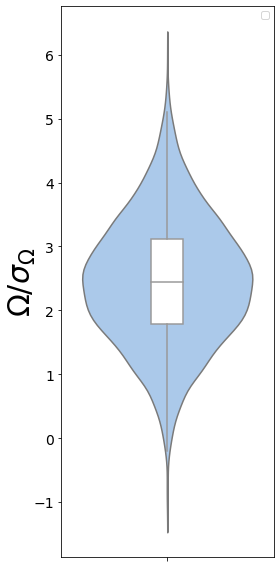

In [21]:
################ histograms of the contour integral distributions ###########

colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]


fig, ax = plt.subplots(figsize=(4,8))#, sharex=True)
#plots
sns.violinplot(data=omegas, y = 'Norm_Omegas',
               palette = colorlist, inner = None, ax=ax)
sns.boxplot(data=omegas,y='Norm_Omegas', width = 0.15, 
        color = 'white', showcaps=False, fliersize=0, boxprops={'zorder': 2}, 
            ax=ax)

#labels
ax.set_ylabel('$Ω/σ_{Ω}$', fontsize=30, labelpad=-5)
ax.set_xlabel('', fontsize=20)
ax.tick_params('y', labelsize=14)
ax.set_xticklabels([''], fontsize = 14)



plt.legend()
plt.tight_layout()

plt.savefig(savedir + f'contour integral of uple{uple} and lori{lori}.png', bbox_inches='tight', dpi = 500)


In [22]:
######### do NORMALIZED contour integrals ################
from CustomFunctions.DetailedBalance import contour_integral

uple = [3,8]
lori = [8,4]
if os.path.exists(savedir+f'Contour_integrals_uple{uple}_lori{lori}_normalized.csv'):
    omegas_norm = pd.read_csv(savedir+f'Contour_integrals_uple{uple}_lori{lori}_normalized.csv', index_col=0)
else:
    omegas = []
    for b in bslist:
        omegas.append(contour_integral(b, uple, lori, norm = True))
    omegas_norm = pd.DataFrame(list(zip(omegas/pd.Series(omegas).std(),['omega']*len(omegas))), columns=['Norm_Omegas','sample'])
    omegas_norm.to_csv(savedir+f'Contour_integrals_uple{uple}_lori{lori}_normalized.csv')

(210.32165930822035, 0.0)


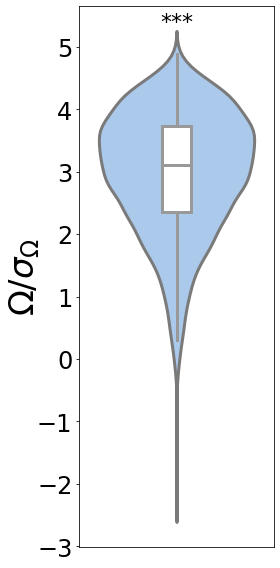

In [38]:
################ histograms of the contour integral distributions ###########
from statsmodels.stats.weightstats import ztest as ztest
colorlist = [list(sns.color_palette('pastel').as_hex())[i] for i in [0,3,8]]


fig, ax = plt.subplots(figsize=(4,8))#, sharex=True)
#plots
sns.violinplot(data=omegas_norm, y = 'Norm_Omegas',
               palette = colorlist, linewidth = 3, inner = None, ax=ax)
sns.boxplot(data=omegas_norm,y='Norm_Omegas', width = 0.15, 
        color = 'white', showcaps=False, fliersize=0, linewidth = 3, boxprops={'zorder': 2}, 
            ax=ax)

#labels
ax.set_ylabel('$Ω/σ_{Ω}$', fontsize=34, labelpad=-5)
ax.set_xlabel('', fontsize=20)
ax.tick_params('y', labelsize=24)
ax.set_xticklabels([''], fontsize = 14)
ax.set_xticks([])

ax.text(0,5.3,'***',fontdict= {'fontsize': 22,
                               'horizontalalignment':'center'})
plt.tight_layout()

plt.savefig(savedir + f'contour integral of uple{uple} and lori{lori} normalized.png', bbox_inches='tight', dpi = 500)
print(str(ztest(omegas_norm.Norm_Omegas, value=0)))

In [ ]:
########################## SIMULATE COMPLETELY EQUAL TRANSITIONS ###################################

################## SIMULATE RANDOM TRANSITIONS FROM A NORMAL DISTIBUTION ##################
#create the normal distributions of both "PCs"
sPC1 = np.random.normal(0,1.5,10000)
sPC2 = np.random.normal(0,1.5,10000)
#generate a random list of index lengths that will count as individual cell tracks 
cells = []
while sum(cells)<len(sPC1):
    cells.append(random.randint(3,100))
#subtract the "overage" of the last number 
cells[-1] = cells[-1] - (sum(cells)-len(sPC1))
#create actual list of "CellID"s
CellIDs = []
for i,x in enumerate(cells):
    CellIDs.extend([f'Cell {i}']*x)
#create dataframe
TotalFrame = 

In [ ]:
################## how are the PC bins changing over time #########################
difflist = []
for i, d in TotalFrame[['CellID','Migration_Mode','frame','PC1bins','PC2bins','PC3bins','PC4bins']].sort_values(by='frame').groupby('CellID'):
    dtemp = d[['frame','PC1bins','PC2bins','PC3bins','PC4bins']].diff()
    dtemp = dtemp[dtemp.frame==1]
    dtemp['frame'] = d.frame[dtemp.index]
    dtemp['CellID'] =  [i]*len(dtemp)
    dtemp['Migration_Mode'] = d.Migration_Mode[dtemp.index]
    difflist.append(dtemp)
diffdf = pd.concat(difflist)

fig, axes = plt.subplots(4, 1, figsize=(20,40), sharey=True)
for a, ax in enumerate(axes):
    cpc = [x for x in diffdf.columns.to_list() if 'PC' in x][a]
    sns.boxplot(data=diffdf, x='frame', hue='Migration_Mode',y=cpc, ax=ax)
    ax.set_xticklabels(
        np.sort(diffdf.frame.unique()).astype(int),
        rotation=-45,
        fontsize = 12
        )
    #set axis titles
    ax.set_ylabel(cpc, fontsize = 30)
    ax.set_xlabel('Frame', fontsize = 22)
plt.tight_layout()
fig.savefig(savedir+'PC bin differentials.png', facecolor='white')

C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Aaron\anaconda3\envs\abhishape\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in 

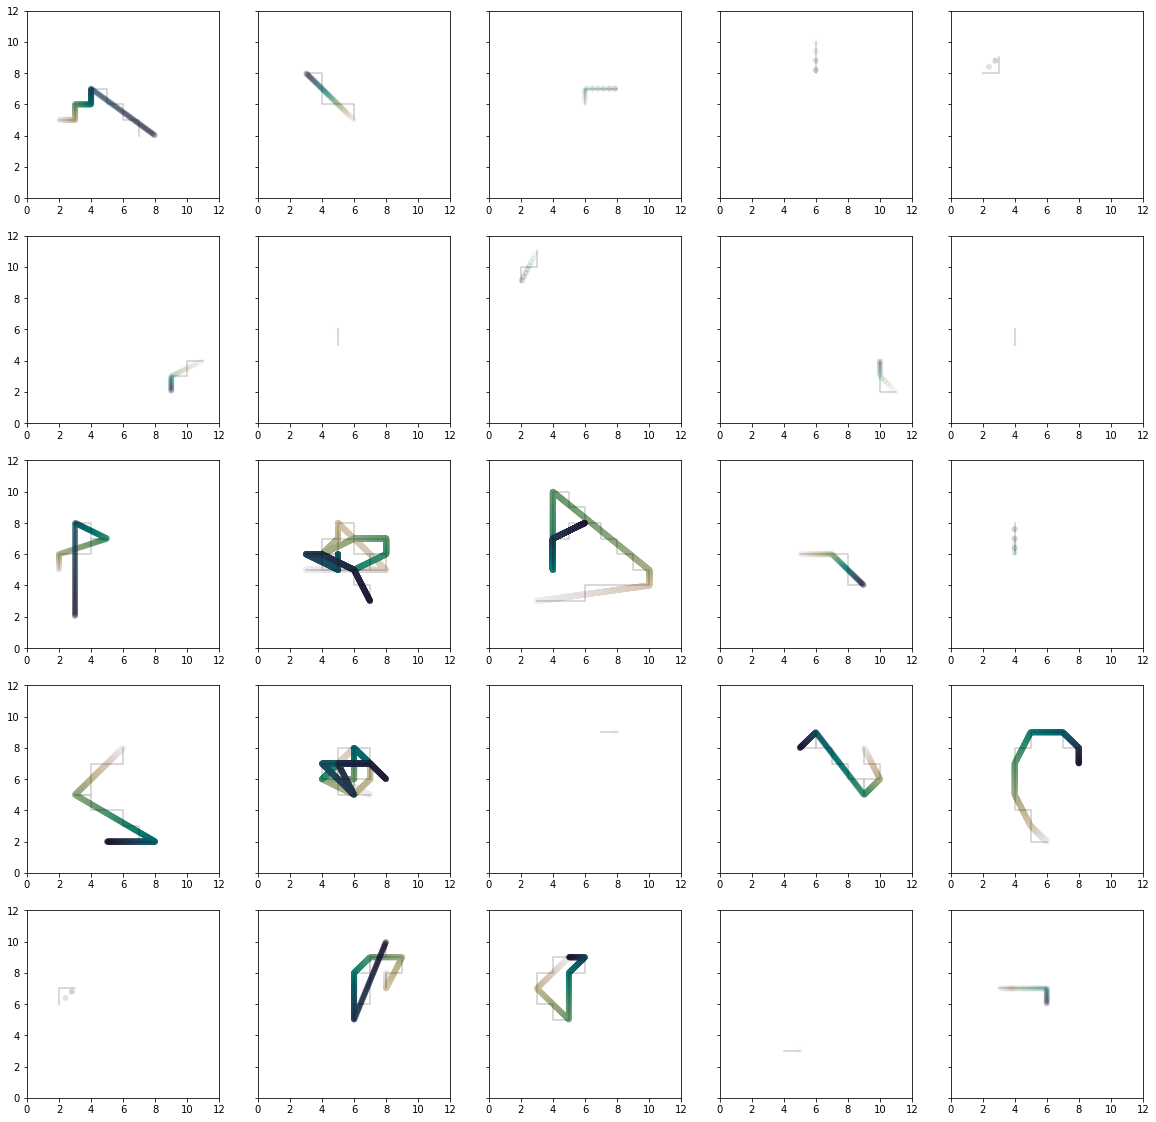

In [45]:
############# grid of plots of individual cells' INTERPOLATED transitions ###################

########### '20230509_488EGFP-CAAX_640SPY650-DNA2_cell_5' performs the exact loop #############

#the square root of plot number
pnum = 5
#randomly choose cells
sample = random.sample(list(transdf.CellID.unique()), pnum**2)

from cmocean import cm
norm = matplotlib.colors.Normalize()
cmm = cm.rain



fig, axes = plt.subplots(pnum,pnum,figsize=(20,20), sharey=True)
s = 0
#make numpy array with heatmap data
for x in range(pnum):
    for y in range(pnum):
        axes[x,y].set_xlim(0,nbins+1)
        axes[x,y].set_ylim(0,nbins+1)
        #get the next cell in the sample
        temp = transdf[transdf.CellID == sample[s]].reset_index(drop=True)
        #if temp is only 1 transition resample
        if len(temp)<2:
            temp = transdf[transdf.CellID == random.sample(list(transdf.CellID.unique()), 1)].reset_index(drop=True)
        #only get continuous frames 
        frames = temp[temp.frame.diff()>1].index.values
        if frames.size>0:
            if temp.index.values[0] != frames[0]:
                frames = np.append(temp.index.values[0], frames)
            if temp.index.values[-1] != frames[-1]:
                frames = np.append(frames, temp.index.values[-1])
            st = random.randrange(len(frames)-1)
            temp = temp.loc[frames[st]:frames[st+1]-1]
#             print(temp)
#         if s == len(sample)-1:
#             temp = alltrans.copy()
#             print(x,y)

        
        #get values of actual transitions based on the interpolated transitions
        fli = temp.frame.to_list()+[temp.frame.to_list()[-1]+1]
        acttemp = TotalFrame[(TotalFrame.CellID==temp.CellID.values[0])&(TotalFrame.frame.isin(fli))].sort_values(by='frame').reset_index(drop=True)
        #interpolate along the trajectory so I can plot dots which will represent the color gradient line
        px = acttemp.PC1bins.to_numpy()
        py = acttemp.PC2bins.to_numpy()
        pz = acttemp.frame.to_numpy()
        dist = np.nansum(scipy.spatial.distance.pdist(temp[['from_x','from_y']]))
        fx = scipy.interpolate.interp1d(np.arange(1,len(px)+1),px)
        newx = fx(np.arange(1,len(px), ((len(px)+1)-1)/(5*dist)))
        fy = scipy.interpolate.interp1d(np.arange(1,len(py)+1),py)
        newy = fy(np.arange(1,len(py), ((len(py)+1)-1)/(5*dist)))
        newz = np.arange(0,len(temp), len(temp)/len(newy))
        if len(newz)>len(newy):
            newz = newz[:-1]
        #normalize to the colors to the length of the trajectory
        norm.autoscale([0,newz.max()])
        #plot the actual transitions
        axes[x,y].scatter(newx,newy, color = cmm(norm(newz)), alpha = 0.2, edgecolors='none')
        
        #plot the interpolated transitions
        ix = np.append(temp.from_x.to_numpy(), temp.to_x.to_numpy()[-1])
        iy = np.append(temp.from_y.to_numpy(), temp.to_y.to_numpy()[-1])
        axes[x,y].plot(ix, iy, color ='black', alpha=0.2)
        
        #add one to the sample count
        s = s+1

In [47]:
############### get shcoeffs for different positions around a particular 2d contour #############
from CustomFunctions.PCvisualization import interpolate_contour_shapes
import pickle as pk
from scipy import interpolate
from scipy.spatial import distance
avgpcs = TotalFrame[[x for x in TotalFrame.columns.to_list() if 'PC' in x and 'bin' not in x]].mean().to_numpy()

pca = pk.load(open(savedir+"pca.pkl",'rb'))

whichpcs = [1,2]
lmax = 10

vertices = np.array([[4,7],
[4,3],
[9,3],
[9,7]])

contour_positions, loopname = interpolate_contour_shapes(vertices,
                               avgpcs,
                               whichpcs,
                               pca,
                               PC1bins,
                               PC2bins,
                               savedir,
                               lmax)

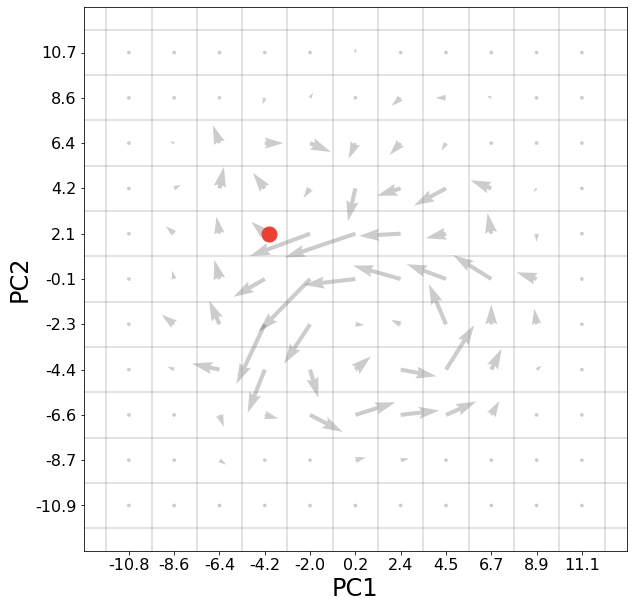

In [48]:
########## animate a contour loop graph
from matplotlib.animation import FuncAnimation 

scale = 0.0005

#make fig
fig, ax = plt.subplots(figsize = (10,10))

#add "grid lines" first 
for h in np.linspace(0.5, nbins+0.5, nbins+1):
    ax.axhline(h, linestyle='-', color='grey', alpha=0.3) # horizontal lines
    ax.axvline(h, linestyle='-', color='grey', alpha=0.3) # vertical lines

    

for x in range(nbins):
    for y in range(nbins):
        current = trans_rate_df[(trans_rate_df['x'] == x+1) & (trans_rate_df['y'] == y+1)]
        xcurrent = (current.x_plus_rate - current.x_minus_rate)/2
        ycurrent = (current.y_plus_rate - current.y_minus_rate)/2
#             print(anglecolor)
        ax.quiver((x+1),
                   (y+1), 
                   xcurrent, 
                   ycurrent,
                  angles = 'xy',
                  scale_units = 'xy',
                  scale = scale,
#                   width = 0.012,
#                   minlength = 0.8,
                  color = 'black',
                 alpha = 0.2)    
    
    

ax.set_aspect("equal")
ax.set_xlabel('PC1', fontsize = 24)
ax.set_ylabel('PC2', fontsize = 24)
ax.set_xticks(list(range(1,nbins+1)),[round((PC1bins[i+1]+x)/2,1) for i,x in enumerate(PC1bins[:-1])], fontsize = 16)
ax.set_yticks(list(range(1,nbins+1)),[round((PC2bins[i+1]+x)/2,1) for i,x in enumerate(PC2bins[:-1])], fontsize = 16)
ax.set_xlim(0,nbins+1)
ax.set_ylim(0,nbins+1)
# ax.set_title(mm, fontsize = 30)


# create a point in the axes
point, = ax.plot(contour_positions[0,1],contour_positions[0,2], marker="o", color = '#eb4034', markersize = 15)

# make function for updating point position
def animate(i, contour_positions):
    point.set_data([contour_positions[i,1]], [contour_positions[i,2]])
    return point,

ani = FuncAnimation(fig, animate, interval=10, blit=True, repeat=True,
                    frames=list(range(len(contour_positions))), fargs = (contour_positions,))
# plt.show()

ani.save(savedir + 'contours/' + loopname + f'/{loopname}_plotanimation_PC1-PC2.mp4', fps=30, dpi = 200)#, extra_args=['-vcodec', 'libx264'])


In [4]:
############## get the actual bin position reconstructions for still images ##########

from CustomFunctions.PCvisualization import mesh_from_bins
import pickle as pk

avgpcs = TotalFrame[[x for x in TotalFrame.columns.to_list() if 'PC' in x and 'bin' not in x and 'dist' not in x]].mean().to_numpy()

pca = pk.load(open(datadir+"pca.pkl",'rb'))

whichpcs = [1,2]
lmax = 10



specific_positions = np.array([
[3,8],
[5.5,8],
[8,8],
[8,6],
[8,4],
[5.5,4],
[3,4],
[3,6]])



for x in specific_positions:
    specificdir = savedir + str(x) + '.vtp'
    mesh_from_bins(x,
                   whichpcs,
                   avgpcs,
                   PC1bins,
                   PC2bins,
                   pca,
                   specificdir,
                   lmax,
                   )
